# PMO - “Módulo inteligente para la toma de decisiones”

![alt text](https://7avp.com/wp-content/uploads/2019/12/data-science-image-banner.jpg)


## Entendimiento del negocio

Actualmente el departamento de proyectos de la empresa Go-Labs Enterprises Solutions S.A cuenta con un sistema de manejo de proyectos llamado "PMO". Esta herramienta de software consta de varios módulos los cuales brindan cierta información sobre los proyectos actuales, tecnologías que se utilizan, miembros de equipo en cada proyecto y otros parámetros los cuales dan a conocer al departamento una vista rápida del estado de estos. 


Por otra parte,  el departamento de proyectos a identificado cierta carencia sobre los estimadores de proyectos ya que estos se crean a criterio experto pero estos una vez creados y almacenados no siempre son implementados en los proyectos.

Por lo cual se genera el siguiente problema:
- **Carencia sobre la toma de decisiones al predecir cual estimador realmente se va a usar en un proyecto**


Además dicho problema genera la siguiente pregunta:
* **¿Cómo predecir si un estimador realmente va a ser usado en un proyecto a partir de cierta información previa?**


## Enfoque Analítico


Las técnicas de aprendizaje automático permiten predecir cierta clasificación sobre algún dato en especifico a partir de dicha información historica. Por lo que, por medio de un **modelo predictivo de clasificación** se predice si una caracteristica de dicho estimador va o no ser implementada en algún proyecto.

Debido a la gran cantidad de algoritmos de clasificación que existen actualmente es que se obta por usar una herramienta como Pycaret para realizar dicha comparación entre modelos para obtar por el más óptimo y adecuado para dichos datos y predicción.

## Requerimiento de los datos

Para el desarrollo de un modelo de clasificación siempre la variable objetivo tiene que ser un dato de tipo categóricos.

El objetivo de la variable a predecir es indicar si dicho estimador fue o no utilizado en algún proyecto. 

El formato de la variable objetivo debería de ser el siguiente:
* *De tipo binario(es usada o no en un proyecto):* **1 (es usada)**, **0 (no es usada)**

El formato para las variables no dependiente pueden tener formatos tanto categóricos como númericos.

 **Fuente de datos**
- El sistema PMO almacena los datos en una base de datos relacional PostgreSQL la cual esta desplegada en AWS. Por lo que, se pueden realizar consultas sobre tablas de datos en especifico para extraer la información en un formato adecuado (.csv, .json, .xls o similares) para su uso.

## Colección de datos

Breviamente se descargaron las tablas sobre los proyectos, estimadores e items de los estimadores desde la base de datos en PostgreSQL, dichos datasets fueron almacenados en la cuenta de Drive para la facilidad de reproducción del mismo.

In [1]:
# Set de librerias 
import pandas as pd
import numpy as np
# Libreria de gráfica
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
!pip install pycaret
# Import
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Cargamos el csv de google drive
from google.colab import drive
drive.mount('/content/drive')
ROOT = "/content/drive/My Drive/PMO Project/datasets/" # Patch donde se encuentran los datasets

Mounted at /content/drive


In [3]:
# Carga de los datesets a usar
projects_df = pd.read_csv(ROOT+"projects.csv")
estimations_df = pd.read_csv(ROOT+"estimations.csv")
bucket_estimation_df = pd.read_csv(ROOT+"bucket_estimation.csv")
bucket_estimation_items_df = pd.read_csv(ROOT+"bucket_estimation_items.csv")

In [4]:
projects_df.shape

(73, 16)

## Entendimiento de los datos

### Entendimiento de los datos - **Dataframe de Proyectos**

Este dataframe contiene información registrada de los proyectos realizados en la empresa Go-Labs (73 registros), tales como:
- ***id:***	Identificador único, númerica
- ***name:*** Nombre del proyecto, categorica
- ***description:*** Descripción del proyecto, categorica
-	***is_confidential:*** Confidencialidad del proyecto, booleana
- ***is_internal:*** Proyecto interno, booleana
-	***type:*** Tipo de proyecto, categorica
-	***state:*** Estado del proyecto, categorica
-	***start_date:*** Fecha de inicio, categorica
-	***end_date:*** Fecha final, categorica
-	***client_id:*** Identificador del cliente, númerica
-	***project_status_id:*** Identificador del estatus del proyecto, númerica
-	***estimation_id:*** Identificador de la estimación, númerica
-	***deleted_at:*** Fecha de eliminación del proyecto en el sistema PMO, categorica
-	***created_at:*** Fecha de creado del proyecto en el sistema PMO, categorica
-	***updated_at:*** Fecha de actualizado del proyecto en el sistema PMO, categorica
-	***closed_at:*** Fecha de cerrado del proyecto en el sistema PMO, categorica

In [5]:
# Vista previa de datos del dataframe de proyectos
projects_df.head()

,id,name,description,is_confidential,is_internal,type,state,start_date,end_date,client_id,project_status_id,estimation_id,deleted_at,created_at,updated_at,closed_at
0,23,Quicktun,<div>System that uses QuickBooks Online (ERP) ...,False,True,Fixed Bid,Completed,2018-07-01 00:00:00,2018-12-31 00:00:00,15,1,NaN,NaN,2020-04-29 18:17:59,2020-04-29 18:17:59,2018-12-31 00:00:00
1,4,QPOS,Working on bug fixing and new features for the...,False,False,Retainer Fee,In Progress,2020-03-16 00:00:00,2020-09-15 00:00:00,14,1,NaN,NaN,2020-03-19 21:18:15,2020-03-19 21:18:15,NaN
2,2,Indeed,Devops projects for a client with 2000+ develo...,True,False,Retainer Fee,In Progress,2020-03-02 00:00:00,2020-12-31 00:00:00,2,1,NaN,NaN,2020-03-16 22:49:34,2020-03-19 23:25:41,NaN
3,3,Avium Steps,Design and implement a workflow with AWS lambd...,True,False,Fixed Bid,Completed,2020-03-18 00:00:00,2020-03-20 00:00:00,8,1,1.0,NaN,2020-03-18 03:52:50,2020-03-20 19:48:57,2020-03-20 00:00:00
4,5,Referenceable,Referenceable is a software that allows compan...,False,False,Fixed Bid,Completed,2019-11-18 00:00:00,2020-05-09 00:00:00,5,1,NaN,NaN,2020-03-25 16:28:57,2020-03-25 16:29:29,2020-05-09 00:00:00


In [6]:
projects_df.info() # Información previa

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 73 non-null     int64  
 1   name               73 non-null     object 
 2   description        73 non-null     object 
 3   is_confidential    73 non-null     bool   
 4   is_internal        73 non-null     bool   
 5   type               73 non-null     object 
 6   state              73 non-null     object 
 7   start_date         73 non-null     object 
 8   end_date           73 non-null     object 
 9   client_id          73 non-null     int64  
 10  project_status_id  73 non-null     int64  
 11  estimation_id      16 non-null     float64
 12  deleted_at         0 non-null      float64
 13  created_at         73 non-null     object 
 14  updated_at         73 non-null     object 
 15  closed_at          59 non-null     object 
dtypes: bool(2), float64(2), int6

In [7]:
# Tamaño del dataframe de proyectos
projects_df.shape 

(73, 16)

In [8]:
# Histograma de tipos de proyecto
fig = px.histogram(projects_df, x="type", title="Histograma de tipos de proyecto")
fig.show()

In [9]:
# Histograma del estado de los proyectos
fig = px.histogram(projects_df, x="state", title="Histograma del estado de los proyectos")
fig.show()

In [10]:
# Histograma de la cantidad de proyectos confidenciales
fig = px.histogram(projects_df, x="is_confidential", title="Histograma de la cantidad de proyectos confidenciales")
fig.show()

In [11]:
fig = px.pie(projects_df, values='client_id', title='Porcentaje de proyectos por id del cliente')
fig.update_traces(textposition='inside', textinfo='percent')
fig.show()

El cliente con el **id 67 es Sula Batsú**, por lo que es el cliente con ***más porcentaje de proyectos*** dentro de la empresa

In [12]:
fig = px.line(projects_df, y='created_at', title='Serie de tiempo de los proyectos creados')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Entendimiento de los datos - **Dataframe de Estimadores**


Este dataframe contiene información registrada de los estimadores de los proyectyos realizados en la empresa Go-Labs (60 registros), tales como:
- ***id:***	Identificador único, númerica
- ***description:*** Descripción, categorica
- ***client_id:*** Identificador del cliente, númerica
-	***created_at:*** Fecha de creado del proyecto en el sistema PMO, categorica
-	***updated_at:*** Fecha de actualizado del proyecto en el sistema PMO, categorica
-	***deleted_at:*** Fecha de eliminación del proyecto en el sistema PMO, categorica
-	***notes:*** Notas, categorica


In [13]:
estimations_df.head()

,id,description,client_id,created_at,updated_at,deleted_at,notes
0,1,Avium Steps,8,2020-03-16 23:31:23,2020-03-16 23:31:23,NaN,NaN
1,2,Local Market,15,2020-03-25 18:01:07,2020-03-25 18:01:07,NaN,NaN
2,3,Liquidation App (Antiblock),12,2020-03-25 21:01:22,2020-03-25 21:01:22,NaN,NaN
3,4,Referenceable transcoder,5,2020-03-26 21:24:52,2020-03-26 21:24:52,NaN,NaN
4,5,Face Recognition Project,18,2020-03-30 22:03:11,2020-03-30 22:03:11,NaN,NaN


In [14]:
estimations_df.info() # Información previa

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           60 non-null     int64 
 1   description  60 non-null     object
 2   client_id    60 non-null     int64 
 3   created_at   60 non-null     object
 4   updated_at   60 non-null     object
 5   deleted_at   2 non-null      object
 6   notes        1 non-null      object
dtypes: int64(2), object(5)
memory usage: 3.4+ KB


In [15]:
estimations_df.shape

(60, 7)

In [16]:
fig = px.line(estimations_df, y='created_at', title='Serie de tiempo de los estimadores creados')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Entendimiento de los datos - **Dataframe del bucket de estimación**

Este dataframe es una tabla intermedia entre los estimadores y sus items (205 registros), tales como:
- ***id:***	Identificador único, númerica
- ***estimation_id:*** Identificador del estimador, númerica
- ***bucket_id:*** Identificador del bucket, númerica
-	***created_at:*** Fecha de creado del proyecto en el sistema PMO, categorica
-	***updated_at:*** Fecha de actualizado del proyecto en el sistema PMO, categorica
- ***order:*** Orden en el que se muestra en el sistema de PMO, númerica


In [17]:
bucket_estimation_df.head()

,id,estimation_id,bucket_id,created_at,updated_at,order
0,1,1,1,NaN,NaN,NaN
1,6,3,8,NaN,NaN,NaN
2,7,3,1,NaN,NaN,NaN
3,8,3,6,NaN,NaN,NaN
4,9,3,7,NaN,NaN,NaN


In [18]:
bucket_estimation_df.shape

(205, 6)

In [19]:
bucket_estimation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             205 non-null    int64  
 1   estimation_id  205 non-null    int64  
 2   bucket_id      205 non-null    int64  
 3   created_at     31 non-null     object 
 4   updated_at     141 non-null    object 
 5   order          130 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.7+ KB


### Entendimiento de los datos - **Dataframe de los items de los estimadores**

Este dataframe contiene información registrada de los items de los estimadores de los proyectyos realizados en la empresa Go-Labs (1422 registros), tales como:
- ***id:***	Identificador único, númerica
- ***description:*** Descripción del item, categorica
- ***hours:*** Horas definidas, númerica
- ***bucket_estimation_id:*** Identificador del bucket de estimación, númerica
-	***created_at:*** Fecha de creado del proyecto en el sistema PMO, categorica
-	***updated_at:*** Fecha de actualizado del proyecto en el sistema PMO, categorica
- ***deliverable_id:*** Identificador del entregable, númerica
- ***order:*** Orden en el que se muestra en el sistema de PMO, númerica


In [20]:
bucket_estimation_items_df.head()

,id,description,hours,bucket_estimation_id,created_at,updated_at,deliverable_id,order
0,1,Learning AWS Step Functions,8,1,2020-03-16 23:33:47,2020-03-16 23:33:47,NaN,0
1,2,Configure workflows,8,1,2020-03-16 23:33:47,2020-03-16 23:33:47,NaN,0
2,3,Deployment to production,8,1,2020-03-16 23:33:47,2020-03-16 23:33:47,NaN,0
3,4,PM,2,1,2020-03-16 23:33:59,2020-03-16 23:33:59,NaN,0
4,6,Pantalla de desbloqueo,8,6,2020-03-25 21:02:06,2020-03-25 21:02:06,NaN,0


In [21]:
bucket_estimation_items_df.shape

(1422, 8)

In [22]:
bucket_estimation_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1422 non-null   int64  
 1   description           1422 non-null   object 
 2   hours                 1422 non-null   int64  
 3   bucket_estimation_id  1422 non-null   int64  
 4   created_at            1422 non-null   object 
 5   updated_at            1422 non-null   object 
 6   deliverable_id        1099 non-null   float64
 7   order                 1422 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 89.0+ KB


In [23]:
bucket_estimation_items_df.describe()

,id,hours,bucket_estimation_id,deliverable_id,order
count,1422.000000,1422.000000,1422.000000,1099.000000,1422.000000
mean,825.722925,20.794655,124.602672,49.641492,7.191280
std,467.668101,29.343485,60.451134,31.758348,7.806508
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,437.250000,8.000000,85.000000,20.000000,1.000000
50%,831.500000,16.000000,131.500000,48.000000,5.000000
75%,1234.750000,24.000000,172.000000,81.000000,11.000000
max,1624.000000,400.000000,220.000000,99.000000,39.000000


El promedio de horas es de 21 apróximadamente

In [24]:
fig = px.violin(bucket_estimation_items_df, y="hours", box=True,points='all', title ="Distribución de las horas de los items")
fig.show()

## Preparación de la información

*Para la preparación de los datos hay tre puntos importantes por realizar:*
- Creación la variable objetivo por medio de los proyectos y los estimadores.
- Realizar la unión de los items y los estimadores para obtener cuál item del estimador fue usado en un proyecto y cúal otro no.
- Procesar el detalle de los items por procesamiento del lenguaje natural creando una incrustación de palabras como parámetros de entrada del modelo.
- Corregir el desequilibrio de la variable objetivo usando SMOTE.


**¿Qué es Pycaret?**
- PyCaret es una biblioteca de aprendizaje automático de código abierto y bajo código en Python que le permite pasar de preparar sus datos a implementar su modelo en cuestión de segundos en el entorno de su computadora portátil.

### Creación de la variable objetivo

In [25]:
# Creación de la variable objetivo
## Si el id del estimador esta en el proyecto es 1 sino 0
estimations_df["is_used"] = estimations_df.id.isin(projects_df.estimation_id).astype(int)

In [26]:
estimations_df.head() 

,id,description,client_id,created_at,updated_at,deleted_at,notes,is_used
0,1,Avium Steps,8,2020-03-16 23:31:23,2020-03-16 23:31:23,NaN,NaN,1
1,2,Local Market,15,2020-03-25 18:01:07,2020-03-25 18:01:07,NaN,NaN,1
2,3,Liquidation App (Antiblock),12,2020-03-25 21:01:22,2020-03-25 21:01:22,NaN,NaN,1
3,4,Referenceable transcoder,5,2020-03-26 21:24:52,2020-03-26 21:24:52,NaN,NaN,1
4,5,Face Recognition Project,18,2020-03-30 22:03:11,2020-03-30 22:03:11,NaN,NaN,1


In [27]:
# Histograma de la cantidad de items usados y no usados en proyectos 
fig = px.histogram(estimations_df, x="is_used", title="Histograma de la cantidad de items usados y no usados en proyectos")
fig.show()

En los estimadores hay 44 que no se usaron y 16 que si 

### Unión de los dataframes de items y estimadores

In [28]:
def merge_estimation_and_items(bucket_estimation_df, bucket_estimation_items_df, estimations_df):
  """ Función la cual realiza el merge entre el los estimadores y los items de estos, retorna el dataframe procesado"""
  # Modificaciones en los id's para hacer la unión
  bucket_estimation_df["bucket_estimation_id"] = bucket_estimation_df["id"] 
  bucket_estimation_df = bucket_estimation_df.drop(columns=['id']) 
  # Merge entre bucket y el item
  df_merged_estimation_item = pd.merge(bucket_estimation_df, bucket_estimation_items_df, on='bucket_estimation_id')
  # Borrado de columnas innecesarias
  df_merged_estimation_item = df_merged_estimation_item.drop(columns=['created_at_x','updated_at_x','order_x','bucket_estimation_id','created_at_y','updated_at_y','order_y'])
  estimations_df["estimation_id"] = estimations_df.id
  estimations_df = estimations_df.drop(columns=["id","updated_at","deleted_at","notes"], axis=1)
  # Merge final con el estimador
  final_df = pd.merge(df_merged_estimation_item,estimations_df, on='estimation_id')
  final_df = final_df.rename(columns={'description_x': 'name' })
  # Cleaning 
  final_df = final_df.drop(columns=['estimation_id','id','bucket_id','deliverable_id','description_y','client_id','created_at'])
  return final_df

In [29]:
df = merge_estimation_and_items(bucket_estimation_df, bucket_estimation_items_df, estimations_df) # Obtención del dataframe procesado

In [30]:
# Agregando la columna length
df['length'] = df.name.str.len()

In [31]:
df.groupby('is_used').mean()

,hours,length
is_used,,
0,22.032468,27.300557
1,16.915698,27.906977


**Nota:** El promedio de la longitud de la descripción de los ítems es muy similar entre los que son usados frente a los que no. Pero en las horas existe una diferencia de promedios de 5 horas apróximadamente.

In [32]:
df.head()

,name,hours,is_used,length
0,Learning AWS Step Functions,8,1,27
1,Configure workflows,8,1,19
2,Deployment to production,8,1,24
3,PM,2,1,2
4,Pantalla de desbloqueo,8,1,22


In [33]:
df.shape

(1422, 4)

In [34]:
df.describe()

,hours,is_used,length
count,1422.000000,1422.000000,1422.000000
mean,20.794655,0.241913,27.447257
std,29.343485,0.428392,18.639616
min,1.000000,0.000000,2.000000
25%,8.000000,0.000000,15.000000
50%,16.000000,0.000000,22.000000
75%,24.000000,0.000000,34.000000
max,400.000000,1.000000,135.000000


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422 entries, 0 to 1421
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     1422 non-null   object
 1   hours    1422 non-null   int64 
 2   is_used  1422 non-null   int64 
 3   length   1422 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 55.5+ KB


In [36]:
df.to_csv('/content/drive/My Drive/PMO Project/final_df.csv', index = False, header=True) # Se guarda el dataframe final

### Procesamiento del lenguaje natural sobre los detalles de los items

**Término Frecuencia-Frecuencia inversa del documento (tf-idf / la frecuencia de ocurrencia del término en la colección de documento)**
- El valor tf-idf aumenta proporcionalmente al número de veces que una palabra aparece en el documento, pero es compensada por la frecuencia de la palabra en la colección de documentos, lo que permite manejar el hecho de que algunas palabras son generalmente más comunes que otras.

In [37]:
# Import 
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
# Agregar los stopwords
stop_words_eng = set(stopwords.words('english')) 
stop_words_sp = set(stopwords.words('spanish')) 
final_stop_words = set(list(stop_words_eng) + list(stop_words_sp))

In [39]:
# Embedding name
vectorizer_name = TfidfVectorizer(stop_words=final_stop_words)
data_name = vectorizer_name.fit_transform(df.name)
tfidf_tokens_name = vectorizer_name.get_feature_names()
result_df = pd.DataFrame(data = data_name.toarray(),columns = tfidf_tokens_name)
result_df

,accept,acceso,access,acción,account,accounts,achievements,acomodo,acorde,actividad,activo,activos,actual,actualización,actualizar,add,adecuada,adjuntar,adjust,admin,administración,administradores,administrar,admins,adversiting,afiliarse,agregar,agrupado,ajuste,ajustes,alarma,album,alcancía,alerta,alertas,alerts,almacenamiento,amazon,ambiente,amenities,...,vencimiento,vendido,vendor,venta,ver,verificación,verificados,versiones,versión,vertical,vez,viabilidad,viajes,video,videos,view,visita,vista,visualizar,votacion,votación,votar,vpcs,wallet,web,website,webview,week,white,wizard,woocommerce,wordpress,work,workers,workflow,workflows,xlsx,yoy,zona,zonas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.751117,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.655754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

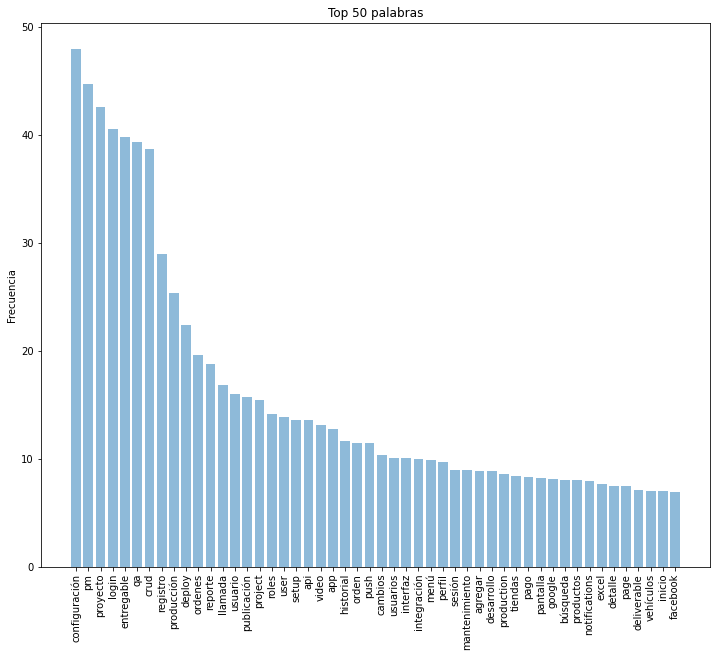

In [40]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, result_df.T.sum(axis=1).sort_values(ascending=False)[:50], align='center', alpha=0.5)
plt.xticks(y_pos, result_df.T.sum(axis=1).sort_values(ascending=False)[:50].index,rotation='vertical')
plt.ylabel('Frecuencia')
plt.title('Top 50 palabras')
plt.show()

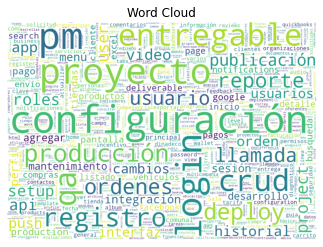

In [41]:
from wordcloud import WordCloud
# Create wordCloud
Cloud = WordCloud( background_color="white",
  max_words=2000,
  width = 1024,
  height = 720,).generate_from_frequencies(result_df.T.sum(axis=1))
# Plot
fig, ax = plt.subplots()
plt.imshow(Cloud)
plt.title('Word Cloud')
plt.axis('off')
plt.show()

In [42]:
# Agregar las horas, longitud y la variable objetivo en los resultados
result_df['hours'] = df.hours
result_df['is_used'] = df.is_used
result_df['length'] = df.length

In [43]:
# Guardar el modelo SMOTE
import joblib
joblib.dump(vectorizer_name, ROOT + 'vectorizer_name_v1.pkl')

['/content/drive/My Drive/PMO Project/datasets/vectorizer_name_v1.pkl']

### Procesamiento SMOTE

Selecciona dos instancias similares utilizando vecinos más cercanos y bootstrapping, y genera muestras sintéticas a partir de instancias de las clases minoritarias.

![work](https://www.bbvadata.com/wp-content/uploads/2017/10/1-3.jpg)

In [44]:
fig = px.histogram(result_df, x="is_used", title="Distribución de la variable objetivo sin SMOTE")
fig.show()

Se obtiene casi un desbalance de la variable objetivo, ya que casi el 75% de los datos son 0 o que no se uso en un proyecto (1078 registros) y el restante que si se uso en los proyectos (344 registros), dando un total de 1422 registros.


In [45]:
oversample = SMOTE()
X, y = oversample.fit_resample(result_df.drop(['is_used'], axis=1), result_df.is_used)

In [46]:
X['is_used'] = y
final_df = X

In [47]:
final_df.shape

(2156, 1033)

In [48]:
fig = px.histogram(final_df, x="is_used", title="Distribución de la variable objetivo con SMOTE")
fig.show()

In [49]:
final_df.head()

,accept,acceso,access,acción,account,accounts,achievements,acomodo,acorde,actividad,activo,activos,actual,actualización,actualizar,add,adecuada,adjuntar,adjust,admin,administración,administradores,administrar,admins,adversiting,afiliarse,agregar,agrupado,ajuste,ajustes,alarma,album,alcancía,alerta,alertas,alerts,almacenamiento,amazon,ambiente,amenities,...,vendor,venta,ver,verificación,verificados,versiones,versión,vertical,vez,viabilidad,viajes,video,videos,view,visita,vista,visualizar,votacion,votación,votar,vpcs,wallet,web,website,webview,week,white,wizard,woocommerce,wordpress,work,workers,workflow,workflows,xlsx,yoy,zona,zonas,length,is_used
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,27,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.751117,0.0,0.0,0.0,0.0,19,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,24,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,22,1


## Modelado

In [50]:
# Importación de módulos de clasificación
from pycaret.classification import * 

In [51]:
#Inicialización del setup (en el Notebook env)
exp_clf = setup(final_df, target = 'is_used',feature_selection = True, fix_imbalance = True, session_id=1)

,Description,Value
0,session_id,1
1,Target,is_used
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(2156, 1033)"
5,Missing Values,False
6,Numeric Features,676
7,Categorical Features,356
8,Ordinal Features,False
9,High Cardinality Features,False


Esta función inicializa el entorno en pycaret y crea la canalización de transformación para preparar los datos para el modelado y la implementación. Se debe llamar a setup () antes de ejecutar cualquier otra función en pycaret. Se necesitan dos parámetros obligatorios: marco de datos {tipo matriz, matriz dispersa} y nombre de la columna de destino. Todos los demás parámetros son opcionales. En este caso, el 'Feature Selection' es True para que seleccione unicamente las columnas que tengan más relevancia con la columna de 'renuncia' y el 'fix_balance' para regular el balance del valor a predecir.


In [52]:
# Comparación entre diferentes modelos clasificatorios
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8833,0.9247,0.8608,0.9079,0.8829,0.7668,0.7692,1.513
rf,Random Forest Classifier,0.8774,0.9404,0.8348,0.9180,0.8740,0.7551,0.7591,1.155
ridge,Ridge Classifier,0.8641,0.0000,0.8634,0.8717,0.8664,0.7282,0.7302,0.335
lr,Logistic Regression,0.8628,0.9083,0.8556,0.8763,0.8641,0.7256,0.7284,1.365
lda,Linear Discriminant Analysis,0.8628,0.9101,0.8842,0.8542,0.8678,0.7253,0.7279,0.918
xgboost,Extreme Gradient Boosting,0.8542,0.9290,0.7958,0.9087,0.8476,0.7090,0.7159,3.758
catboost,CatBoost Classifier,0.8535,0.9333,0.7854,0.9171,0.8452,0.7078,0.7167,8.819
dt,Decision Tree Classifier,0.8495,0.8803,0.8036,0.8936,0.8450,0.6995,0.7050,0.362
qda,Quadratic Discriminant Analysis,0.8277,0.8245,0.9935,0.7504,0.8548,0.6530,0.6932,0.740
ada,Ada Boost Classifier,0.8244,0.8961,0.7490,0.8909,0.8127,0.6497,0.6597,0.635


Esta función usa todos los modelos en la biblioteca de modelos y los califica usando [Validación cruzada estratificada](https://qastack.mx/stats/117643/why-use-stratified-cross-validation-why-does-this-not-damage-variance-related-b#:~:text=La%20validaci%C3%B3n%20cruzada%20estratificada%20permite,tengan%20algunas%20de%20ambas%20clases.&text=Como%20puede%20ver%2C%20en%20un,una%20distribuci%C3%B3n%20similar%20por%20azar.). La salida imprime una cuadrícula de puntaje que muestra Precisión, AUC, Recuperación, Precisión, F1,  Kappa y MCC(coeficiente de correlación de Matthews) por pliegue (CV predeterminado = 10 pliegues) de todos los modelos disponibles en la biblioteca de modelos.


El modelo a seleccionar va a ser el de 
Extra Trees Classifier, este debido a criterio experto del Kappa y del MCC más alto.


![work](https://www.researchgate.net/profile/Sani_M_Isa/publication/260157307/figure/tbl1/AS:392403237261320@1470567630728/Interpretation-of-Kappa-Statistic-21.png)

![work](https://slideplayer.com/slide/7857836/25/images/9/Matthews+correlation+coefficient+%28MCC%29.jpg)


In [55]:
et = create_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8808,0.8976,0.8442,0.9155,0.8784,0.7619,0.7643
1,0.9139,0.9548,0.8701,0.9571,0.9116,0.8281,0.8316
2,0.9007,0.9461,0.9091,0.8974,0.9032,0.8012,0.8013
3,0.8808,0.9224,0.8182,0.9403,0.8750,0.7621,0.7689
4,0.9404,0.9804,0.8961,0.9857,0.9388,0.8810,0.8848
5,0.8808,0.9165,0.8442,0.9155,0.8784,0.7619,0.7643
6,0.8609,0.9096,0.8831,0.8500,0.8662,0.7215,0.7221
7,0.8609,0.8786,0.8831,0.8500,0.8662,0.7215,0.7221
8,0.8808,0.9435,0.8312,0.9275,0.8767,0.7620,0.7663
9,0.8333,0.8970,0.8289,0.8400,0.8344,0.6667,0.6667


## Evaluación

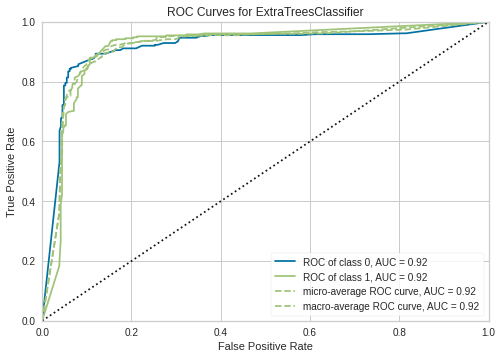

In [59]:
plot_model(et)

In [60]:
# Validar la predicción con datos de prueba
df_prediction = predict_model(et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8733,0.9161,0.8414,0.8874,0.8638,0.7454,0.7464


In [61]:
# Evalaución del modelo 
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [62]:
#Guardar el modelo entrenado
save_model(et, '/content/drive/My Drive/PMO Project/Models/' + 'et_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='is_used',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nod